In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Downloading data

In [2]:
# CIFAR dataset consists of 32*32 labeled images which belong to 10 different classes: airplane, dog, bird, etc.
#!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P datasets

--2022-08-30 15:17:19--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘datasets/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162,60M  27,3MB/s    in 6,7s    

2022-08-30 15:17:27 (24,3 MB/s) - ‘datasets/cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
# Untar and unzipp the files
#!tar xf datasets/cifar-10-python.tar.gz -C datasets

### Reading data, reshaping it, having a look at the data

In [5]:
with open('datasets/cifar-10-batches-py/data_batch_1', 'rb') as input_file:
    X = pickle.load(input_file, encoding='latin1')

In [6]:
X = X['data']
X.shape # batch_size, hight*width*channels

(10000, 3072)

In [7]:
X = X.reshape((-1, 3, 32, 32))
X.shape

(10000, 3, 32, 32)

In [8]:
# batch_size, channels, hight, width -->> batch_size, height, width, channels
X = X.transpose(0, 2, 3, 1)
X.shape

(10000, 32, 32, 3)

In [9]:
# To get back to the original format:
X = X.reshape(-1, 3*32*32)
X.shape

(10000, 3072)

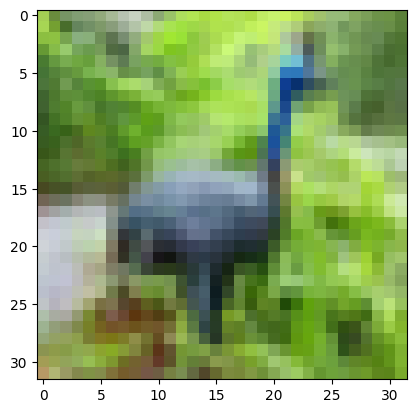

In [10]:
plt.imshow(X[6].reshape(32, 32, 3))
plt.show()

In [11]:
# It is useful to center your data
X = X - X.mean(axis=0)
X = X/np.std(X, axis=0)

In [12]:
# helper function to show standardized image
def show(i):
    
    i = i.reshape((32, 32, 3))
    m, M = i.min(), i.max()
    
    plt.imshow((i-m)/(M-m))  #scale all pixels to be within 0 and 1
    plt.show()

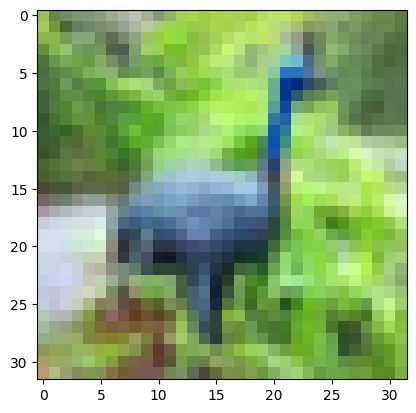

In [13]:
show(X[6]) # showing standardized image

### Using Whitening to Decorrelate Features

In [14]:
X_subset = X[:1000]
X_subset.shape

(1000, 3072)

Whitening is a transformation of data in such a way that its covariance matrix is the identity matrix -- the effect of whitening is to decorrelate features.

In [16]:
# Calculating the covariance matrix of our images
cov = np.cov(X_subset, rowvar=True)
cov.shape

(1000, 1000)

In [18]:
# Decomposing matrix using Singular Value Decomposition (or SVD)
U, S, V = np.linalg.svd(cov)

print(U.shape)
print(S.shape)
print(V.shape)

(1000, 1000)
(1000,)
(1000, 1000)


In [20]:
# Extracting Latent Factors - calculating the principal components of the image features

epsilon = 1e-5 # used to avoid devision by 0
zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S+epsilon)), U.T))

zca_matrix.shape

(1000, 1000)

In [22]:
# Multiplication of principal components by the original matrix is WHITENING
zca = np.dot(zca_matrix, X_subset)

zca.shape

(1000, 3072)

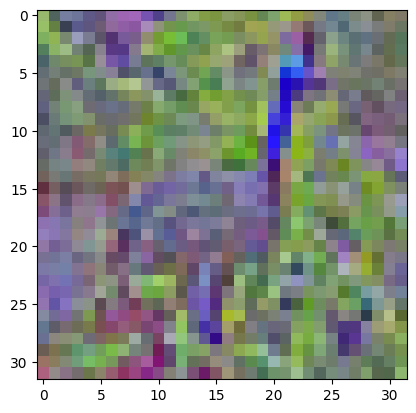

In [24]:
show(zca[6])

### Image Tranformations using PyTorch

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms # contains a number of transformations

In [29]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [32]:
# All transformation techniques can be applied in a sequence

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [33]:
# Loading images in PyTorch dataset
dataset = torchvision.datasets.CIFAR10(root='.datasets/cifar10/train', 
                                      download= True, 
                                      transform=transform)

100.0%


Extracting .datasets/cifar10/train/cifar-10-python.tar.gz to .datasets/cifar10/train


In [34]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [35]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16, 
                                         shuffle=True,
                                         num_workers=2)

In [38]:
image_batch, labels_batch = iter(dataloader).next()

print('image_batch.shape: ', image_batch.shape)
print('labels_batch.shape: ', labels_batch.shape)
print('labels_batch: ', labels_batch)

image_batch.shape:  torch.Size([16, 3, 256, 256])
labels_batch.shape:  torch.Size([16])
labels_batch:  tensor([6, 7, 1, 9, 5, 1, 5, 2, 5, 4, 9, 5, 0, 0, 0, 1])


In [39]:
img = torchvision.utils.make_grid(image_batch)
img.shape

torch.Size([3, 518, 2066])

In [40]:
img = np.transpose(img, (1,2,0)) # transforming formats for matplotlib display
img.shape

torch.Size([518, 2066, 3])

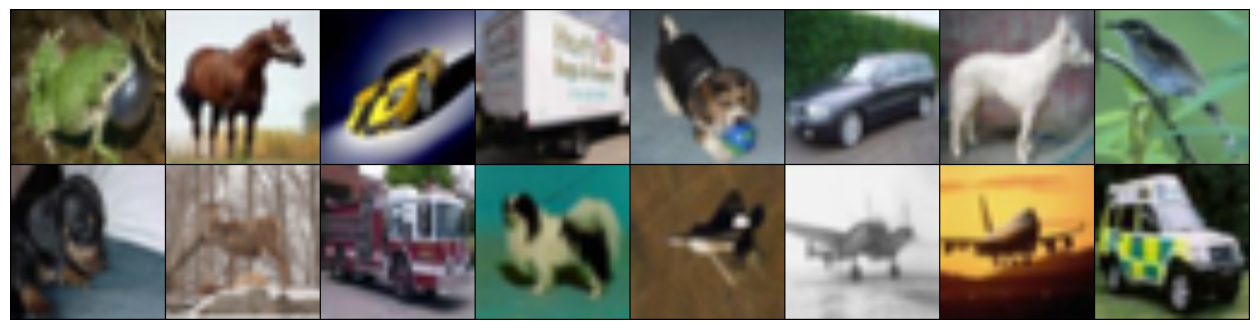

In [41]:
# Displaying batch with Matplotlib
plt.figure(figsize= (16, 12))

plt.imshow(img)
plt.axis('off')
plt.show()

### Normalizing images

In [46]:
pop_mean = []
pop_std = []

for i, data in enumerate(dataloader, 0):
    
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

In [47]:
# converting lists to numpy arrays
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

pop_mean.shape, pop_std.shape # mean and std for all 3 channels

((3125, 3), (3125, 3))

In [48]:
# Average of average values is a fairily close approximation
pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

In [49]:
print(pop_mean)
print(pop_std)

[0.49159133 0.48234585 0.44671956]
[0.23819901 0.23482068 0.2526521 ]


In [51]:
# Applying some transformations on images before feeding them in
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(pop_mean, pop_std) # Normalizing = subrtacting the mean and deviding by std
])

In [52]:
trainset = torchvision.datasets.CIFAR10(root='.datasets/cifar10/train', 
                                        download= True, 
                                        transform=transform)

Files already downloaded and verified


In [53]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

In [54]:
image_batch, labels_batch = iter(trainloader).next()

image_batch.shape, labels_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [62]:
img = torchvision.utils.make_grid(image_batch)
img.shape

torch.Size([3, 454, 1810])

In [63]:
img = np.transpose(img, (1,2,0)) 
img.shape

torch.Size([454, 1810, 3])

In [64]:
m, M = img.min(), img.max()
m, M

(tensor(-2.0638), tensor(2.2045))

In [67]:
# Scaling the normalized image to the range 0,1
img = (1/(abs(m)*M)) * img + 0.5

In [68]:
img

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.9547, 0.9699, 0.9575],
         ...,
         [0.9293, 0.8928, 0.9029],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        ...,

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.6326, 0.5587, 0.5208],
         ...,
         [0.8714, 0.8781, 0.9233],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.

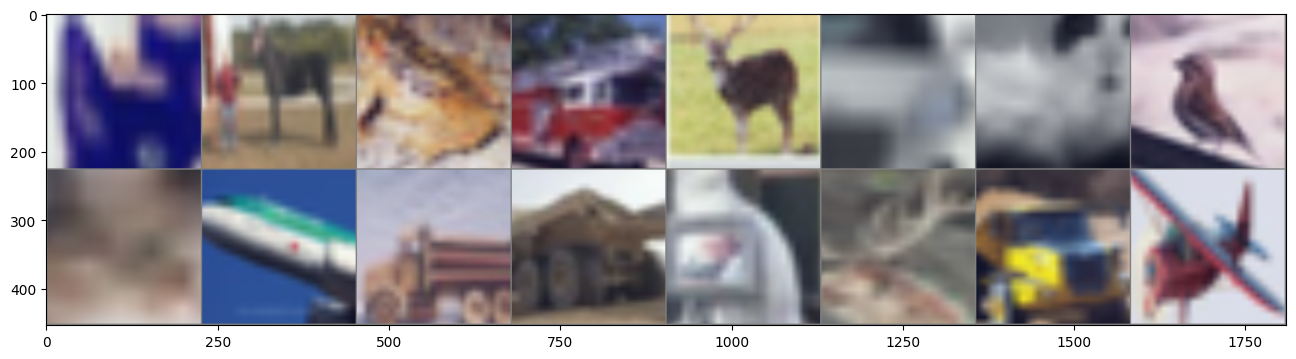

In [69]:
plt.figure(figsize= (16, 12))

plt.imshow(img)
plt.show()